## Import Modules

In [94]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from tqdm import tqdm
import re  
from sklearn.linear_model import LinearRegression
from scipy.stats import ttest_rel, ttest_ind

## Define functions

In [95]:
def convert_to_code_path(windows_path):
    """
    Converts a Windows file path with single backslashes to a format with double backslashes for use in Python code.

    Parameters:
    - windows_path: str
        The original Windows file path (e.g., 'C:\\Users\\YourName\\Folder').

    Returns:
    - str
        The modified path with double backslashes, suitable for Python (e.g., 'C:\\\\Users\\\\YourName\\\\Folder').
    """
    # Replace each single backslash with a double backslash
    return windows_path.replace("\\", "\\\\")

## This doesn't exclude movies without any growth cones
# def extract_length_area_and_relative_angles(main_folder):
#     """
#     Function to extract length, area, relative angles, and count oriented/non-oriented growth cones.

#     Args:
#     - main_folder: Path to the main folder containing the data.

#     Returns:
#     - folder_names: List of subfolder names for labeling in scatter plot.
#     - all_angles: List of tuples containing relative angle, subfolder color, and first-level folder name.
#     - area_values: List of 'Area' values for radius.
#     - length_values: List of 'Length' values for scatter sizes.
#     - first_level_colors: Dictionary mapping first-level folders to colors.
#     - oriented_counts: Dictionary storing oriented growth cone counts (0-15 degrees) for each level-2 subfolder.
#     - non_oriented_counts: Dictionary storing non-oriented growth cone counts (15-90 degrees) for each level-2 subfolder.
#     """
    
#     relative_angles = []  # To store relative angles
#     folder_names = []     # To store subfolder names for labeling in scatter plot
#     all_angles = []       # To store all relative angles
#     area_values = []      # To store the 'Area' values for radius
#     length_values = []    # To store the 'Length' values for scatter sizes

#     # Dictionary to map first-level folders to colors
#     first_level_colors = {}
#     color_count = 0

#     # Nested dictionaries to store counts of oriented and non-oriented cones for each level-2 subfolder
#     oriented_counts = {}
#     non_oriented_counts = {}

#     # Traverse through subfolders
#     for root, dirs, files in os.walk(main_folder):
#         current_depth = root.count(os.sep)
#         target_depth = main_folder.count(os.sep) + 2  # Level-2 subfolder depth
        
#         if current_depth == target_depth:
#             subfolder = os.path.basename(root)  # Get second-level folder name
#             first_level_folder = os.path.basename(os.path.dirname(root))  # Get first-level folder name

#             # Assign color to the first-level folder if not already assigned
#             if first_level_folder not in first_level_colors:
#                 first_level_colors[first_level_folder] = folder_colors[color_count % len(folder_colors)]
#                 color_count += 1

#             # Initialize the dictionary for the first-level folder if not already present
#             if first_level_folder not in oriented_counts:
#                 oriented_counts[first_level_folder] = {}
#                 non_oriented_counts[first_level_folder] = {}

#             # Initialize the counts for the current level-2 subfolder
#             oriented_counts[first_level_folder][subfolder] = 0
#             non_oriented_counts[first_level_folder][subfolder] = 0

#             # Get the color for this subfolder based on its first-level folder
#             subfolder_color = first_level_colors[first_level_folder]

#             angle_deg = None

#             # Load 'skeleton_orientation.mat' file in the current second-level subfolder
#             for file in files:
#                 if file.endswith('skeleton_orientation.mat'):
#                     mat_path = os.path.join(root, file)
#                     try:
#                         mat_data = loadmat(mat_path)
#                         if 'angle_deg' in mat_data:
#                             angle_deg = mat_data['angle_deg'].flatten()[0]  # Extract single angle value
#                     except Exception as e:
#                         print(f"Error loading {mat_path}: {e}")

#             if angle_deg is None:
#                 continue

#             # Process CSV files within the same subfolder
#             for file in files:
#                 if file.startswith('Results') and file.endswith('.csv'):
#                     file_path = os.path.join(root, file)
#                     try:
#                         df = pd.read_csv(file_path)

#                         # Retrieve the first 'Angle' value from the CSV
#                         if 'Angle' in df.columns:
#                             csv_angle = df['Angle'].iloc[0]

#                             # Convert csv_angle to its perpendicular value and restrict to 0-180 degrees
#                             csv_angle_perpendicular = (csv_angle + 90) % 180
#                             if csv_angle_perpendicular < 0:
#                                 csv_angle_perpendicular += 180

#                             # Calculate the relative angle (difference)
#                             relative_angle = abs(csv_angle_perpendicular - angle_deg)

#                             # ** Filter relative angles to only be within 0-90 degrees **
#                             if relative_angle > 90:
#                                 relative_angle = 180 - relative_angle
#                             if relative_angle > 90:
#                                 continue  # Skip values outside the first quadrant

#                             # Store relative angles for plotting
#                             relative_angles.append(relative_angle)

#                             # Store the 'Area' value for radius
#                             if 'Area' in df.columns:
#                                 area_value = df['Area'].iloc[1]  # Assume second row contains 'Area'
#                                 area_values.append(area_value)

#                             # Store the 'Length' value for scatter size
#                             if 'Length' in df.columns:
#                                 length_value = df['Length'].iloc[0]  # Assume first row contains 'Length'
#                                 length_values.append(length_value)

#                             # Store the subfolder name and relative angle for plotting
#                             folder_names.append(subfolder)
#                             all_angles.append((relative_angle, subfolder_color, first_level_folder))

#                             # Count oriented/non-oriented growth cones based on relative angle
#                             if 0 <= relative_angle <= 15:  # Oriented cones
#                                 oriented_counts[first_level_folder][subfolder] += 1
#                             elif 15 < relative_angle <= 90:  # Non-oriented cones
#                                 non_oriented_counts[first_level_folder][subfolder] += 1

#                     except Exception as e:
#                         print(f"Error processing file {file_path}: {e}")

#     return folder_names, all_angles, area_values, length_values, first_level_colors, oriented_counts, non_oriented_counts


## This excludes movies without any growth cones
def extract_length_area_and_relative_angles(main_folder):
    """
    Function to extract length, area, relative angles, and count oriented/non-oriented growth cones.

    Args:
    - main_folder: Path to the main folder containing the data.

    Returns:
    - folder_names: List of subfolder names for labeling in scatter plot.
    - all_angles: List of tuples containing relative angle, subfolder color, and first-level folder name.
    - area_values: List of 'Area' values for radius.
    - length_values: List of 'Length' values for scatter sizes.
    - first_level_colors: Dictionary mapping first-level folders to colors.
    - oriented_counts: Dictionary storing oriented growth cone counts (0-15 degrees) for each level-2 subfolder.
    - non_oriented_counts: Dictionary storing non-oriented growth cone counts (15-90 degrees) for each level-2 subfolder.
    """
    
    relative_angles = []  # To store relative angles
    folder_names = []     # To store subfolder names for labeling in scatter plot
    all_angles = []       # To store all relative angles
    area_values = []      # To store the 'Area' values for radius
    length_values = []    # To store the 'Length' values for scatter sizes

    # Dictionary to map first-level folders to colors
    first_level_colors = {}
    color_count = 0

    # Nested dictionaries to store counts of oriented and non-oriented cones for each level-2 subfolder
    oriented_counts = {}
    non_oriented_counts = {}

    # Traverse through subfolders
    for root, dirs, files in os.walk(main_folder):
        current_depth = root.count(os.sep)
        target_depth = main_folder.count(os.sep) + 2  # Level-2 subfolder depth
        
        if current_depth == target_depth:
            subfolder = os.path.basename(root)  # Get second-level folder name
            first_level_folder = os.path.basename(os.path.dirname(root))  # Get first-level folder name

            # Check if 'Results.csv' file exists in the subfolder
            results_files = [f for f in files if f.startswith('Results') and f.endswith('.csv')]
            if not results_files:
                continue  # Skip this subfolder if no 'Results.csv' file is present

            # Assign color to the first-level folder if not already assigned
            if first_level_folder not in first_level_colors:
                first_level_colors[first_level_folder] = folder_colors[color_count % len(folder_colors)]
                color_count += 1

            # Initialize the dictionary for the first-level folder if not already present
            if first_level_folder not in oriented_counts:
                oriented_counts[first_level_folder] = {}
                non_oriented_counts[first_level_folder] = {}

            # Initialize the counts for the current level-2 subfolder
            oriented_counts[first_level_folder][subfolder] = 0
            non_oriented_counts[first_level_folder][subfolder] = 0

            # Get the color for this subfolder based on its first-level folder
            subfolder_color = first_level_colors[first_level_folder]

            angle_deg = None

            # Load 'skeleton_orientation.mat' file in the current second-level subfolder
            for file in files:
                if file.endswith('skeleton_orientation.mat'):
                    mat_path = os.path.join(root, file)
                    try:
                        mat_data = loadmat(mat_path)
                        if 'angle_deg' in mat_data:
                            angle_deg = mat_data['angle_deg'].flatten()[0]  # Extract single angle value
                    except Exception as e:
                        print(f"Error loading {mat_path}: {e}")

            if angle_deg is None:
                continue

            # Process CSV files within the same subfolder
            for file in results_files:  # Now we process only the Results.csv files
                file_path = os.path.join(root, file)
                try:
                    df = pd.read_csv(file_path)

                    # Retrieve the first 'Angle' value from the CSV
                    if 'Angle' in df.columns:
                        csv_angle = df['Angle'].iloc[0]

                        # Convert csv_angle to its perpendicular value and restrict to 0-180 degrees
                        csv_angle_perpendicular = (csv_angle + 90) % 180
                        if csv_angle_perpendicular < 0:
                            csv_angle_perpendicular += 180

                        # Calculate the relative angle (difference)
                        relative_angle = abs(csv_angle_perpendicular - angle_deg)

                        # ** Filter relative angles to only be within 0-90 degrees **
                        if relative_angle > 90:
                            relative_angle = 180 - relative_angle
                        if relative_angle > 90:
                            continue  # Skip values outside the first quadrant

                        # Store relative angles for plotting
                        relative_angles.append(relative_angle)

                        # Store the 'Area' value for radius
                        if 'Area' in df.columns:
                            area_value = df['Area'].iloc[1]  # Assume second row contains 'Area'
                            area_values.append(area_value)

                        # Store the 'Length' value for scatter size
                        if 'Length' in df.columns:
                            length_value = df['Length'].iloc[0]  # Assume first row contains 'Length'
                            length_values.append(length_value)

                        # Store the subfolder name and relative angle for plotting
                        folder_names.append(subfolder)
                        all_angles.append((relative_angle, subfolder_color, first_level_folder))

                        # Count oriented/non-oriented growth cones based on relative angle
                        if 0 <= relative_angle <= 15:  # Oriented cones
                            oriented_counts[first_level_folder][subfolder] += 1
                        elif 15 < relative_angle <= 90:  # Non-oriented cones
                            non_oriented_counts[first_level_folder][subfolder] += 1

                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")

    return folder_names, all_angles, area_values, length_values, first_level_colors, oriented_counts, non_oriented_counts




## Data Extraction and Plotting
### Growth Cone Relative Orientation with varying Sizes

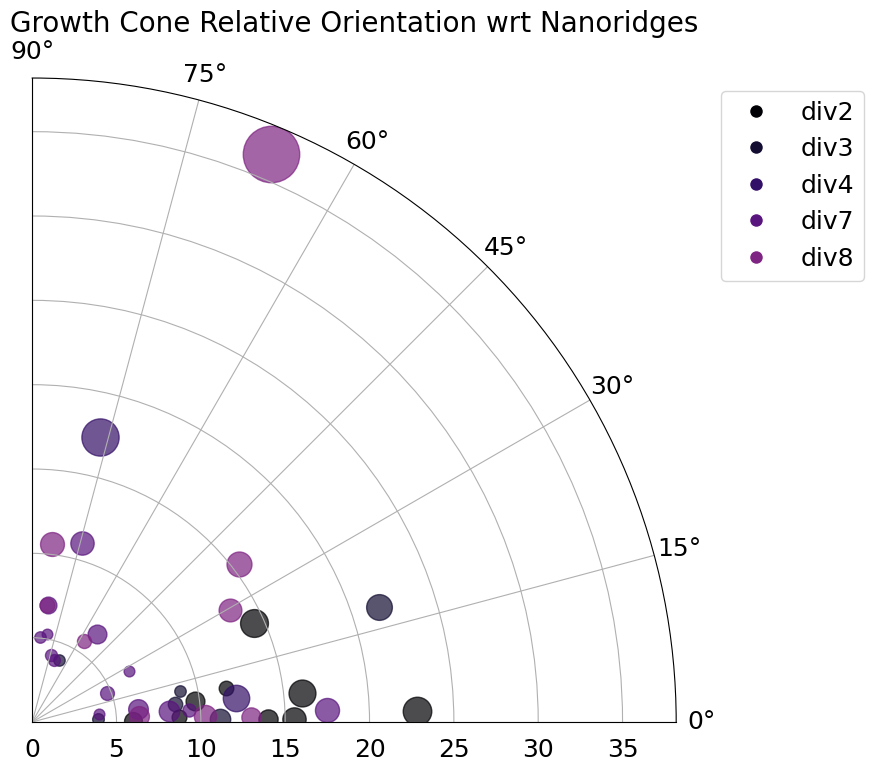

In [96]:
# Initialize the colormap
cmap = plt.colormaps.get_cmap("magma")

# Define the main folder
main_folder = r'E:\Spandan\2D_Neurons_Paper\Ridges'

# Access 'n' colors from the colormap
n = len([name for name in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, name))])  # Count level-1 subfolders 
folder_colors = [cmap(i / n) for i in range(n)]  # Normalize i to be between 0 and 1


# Extract relative angles, area values, length values, and folder information
folder_names, all_angles, area_values, length_values, first_level_colors, oriented_counts, non_oriented_counts = extract_length_area_and_relative_angles(main_folder)

# Set up the polar plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='polar')
plt.rcParams.update({'font.size': 16})  # Increase global font size

# Set angular limits to only display the first quadrant (0 to π/2 or 90 degrees)
ax.set_thetamin(0)  # Start at 0 degrees
ax.set_thetamax(90)  # End at 90 degrees

# Initialize variables to track the largest and smallest scatter sizes
largest_scatter_size = 0
smallest_scatter_size = float('inf')  # Start with a very high value

# Plot the relative angles with 'area_values' as radius and 'length_values' for scatter sizes
for i, ((relative_angle, color, first_level_folder), area, length) in enumerate(zip(all_angles, area_values, length_values)):
    angle_rad = np.deg2rad(relative_angle)  # Convert relative angle to radians for polar plot

    # The size of each scatter point will be proportional to its corresponding 'length_value'
    scatter_size = length**2 * 15 # Scale the length for better visualization

    # Update largest and smallest scatter sizes
    largest_scatter_size = max(largest_scatter_size, scatter_size)
    smallest_scatter_size = min(smallest_scatter_size, scatter_size)

    ax.scatter(angle_rad, area, s=scatter_size, color=color, alpha=0.7, label=first_level_folder if i == folder_names.index(folder_names[i]) else "")

# Set title with increased font size
plt.title('Growth Cone Relative Orientation wrt Nanoridges', fontsize=20)

# Create a legend based on the unique first-level folders and their assigned colors
unique_folders = {}
for first_level_folder, color in first_level_colors.items():
    unique_folders[first_level_folder] = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=first_level_folder)

# Add a legend (one entry per first-level folder)
plt.legend(handles=unique_folders.values(), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=18)

# Increase tick sizes for better visibility
ax.tick_params(axis='both', which='major', labelsize=18, size=8, width=2)  # Adjust tick parameters

# Adjust layout for better fit
plt.tight_layout()

# Show the polar plot
plt.show()

# Save as SVG with highest resolution
# fig.savefig(main_folder + '\\ridges_growth_cone_angle_vs_area.svg', format='svg', bbox_inches='tight')


### Check which movies have very low orientation values

In [97]:
for i in tqdm(range(len(folder_names))):
    ang = all_angles[i][0]
    if ang>60:
        print(ang,length_values[i],folder_names[i])

100%|██████████| 40/40 [00:00<?, ?it/s]

67.13751441185194 2.116 ridges_2021_04_16_well2_timelapse1_PFS
76.68226367289463 6.922 ridges_2019_02_11_C2_ridges_timelapse1
74.3876481841641 4.338 ridges_2019_01_21_B1_ridges_timelapse1
74.39916219338448 2.238 ridges_2019_01_21_B2_ridges_timelapse4
70.90583780661552 2.211 ridges_2019_01_21_B2_ridges_timelapse4
82.53367917709126 3.127 ridges_2021_04_16_MAX_well1_div7ridges_timelapse4
84.57232082290875 2.13 ridges_2021_04_16_MAX_well1_div7ridges_timelapse4
80.35867917709125 1.978 ridges_2021_04_16_MAX_well1_div7ridges_timelapse4
67.25356179688136 10.49 ridges_2019_02_11_C2_ridges_timelapse1
82.94259051364818 2.748 ridges_2019_02_11_C2_ridges_timelapse4
83.62240948635181 4.442 ridges_2019_02_11_C2_ridges_timelapse4


### For reference plotting the largest, and smallest width value

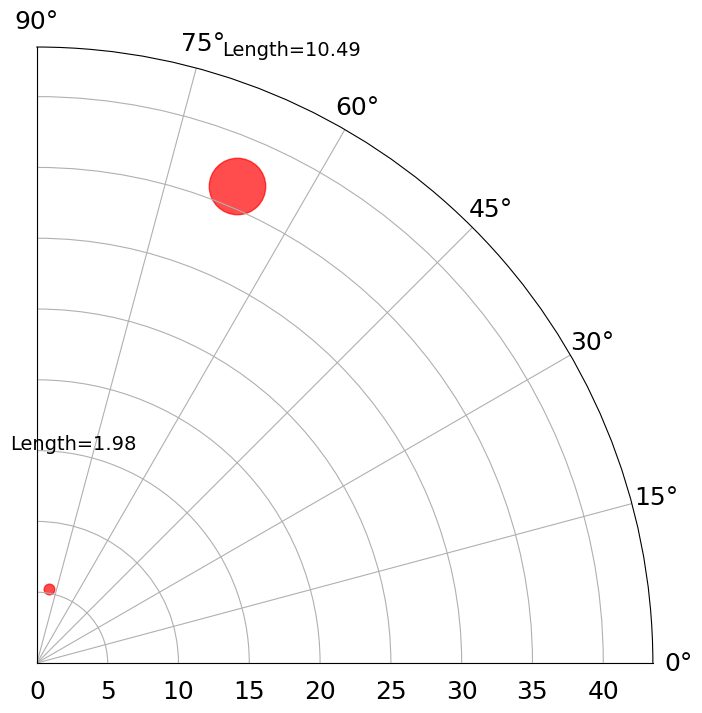

In [98]:
# Define the main folder and initialize the colormap
main_folder = r'E:\Spandan\2D_Neurons_Paper\Ridges'
scatter_size = [smallest_scatter_size, largest_scatter_size]
cmap = plt.colormaps.get_cmap("magma")

# Extract relative angles, area values, length values, and folder information
folder_names, all_angles, area_values, length_values, first_level_colors, oriented_counts, non_oriented_counts = extract_length_area_and_relative_angles(main_folder)

# Identify the largest and smallest length values
min_length, max_length = min(length_values), max(length_values)

# Collect specific points based on the identified lengths
specific_data = [(angle[0] if isinstance(angle, tuple) else angle, area, length) 
                 for angle, area, length in zip(all_angles, area_values, length_values) 
                 if length in {min_length, max_length}]

# Set up a new polar plot for these points only
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': 'polar'})
plt.rcParams.update({'font.size': 16})  # Increase global font size

# Set angular limits to only display the first quadrant (0 to π/2 or 90 degrees)
ax.set_thetamin(0)
ax.set_thetamax(90)

# Plot and annotate specific points
for i, (angle, area, length) in enumerate(specific_data):
    if 0 <= angle <= 90:
        angle_rad = np.deg2rad(angle)  # Convert to radians
        ax.scatter(angle_rad, area, s=scatter_size[i], color='red', alpha=0.7)

        # Annotate each point on top of the scatter
        ax.annotate(f'Length={length:.2f}', xy=(angle_rad, area), xytext=(angle_rad, area + 10),
                    fontsize=14, color='black', ha='center')  # Adjusted vertical position
ax.set_rmax(max_length + largest_scatter_size / 50)  # Add some padding based on the largest scatter size

# Increase tick sizes for better visibility
ax.tick_params(axis='both', which='major', labelsize=18, size=8, width=2)

plt.show()  # Show the polar plot
# Save as SVG with highest resolution
# fig.savefig(main_folder + '\\ridges_growth_cone_angle_vs_area_annotated.svg', format='svg', bbox_inches='tight')


### Growth Cone Relative Orientation with varying widths

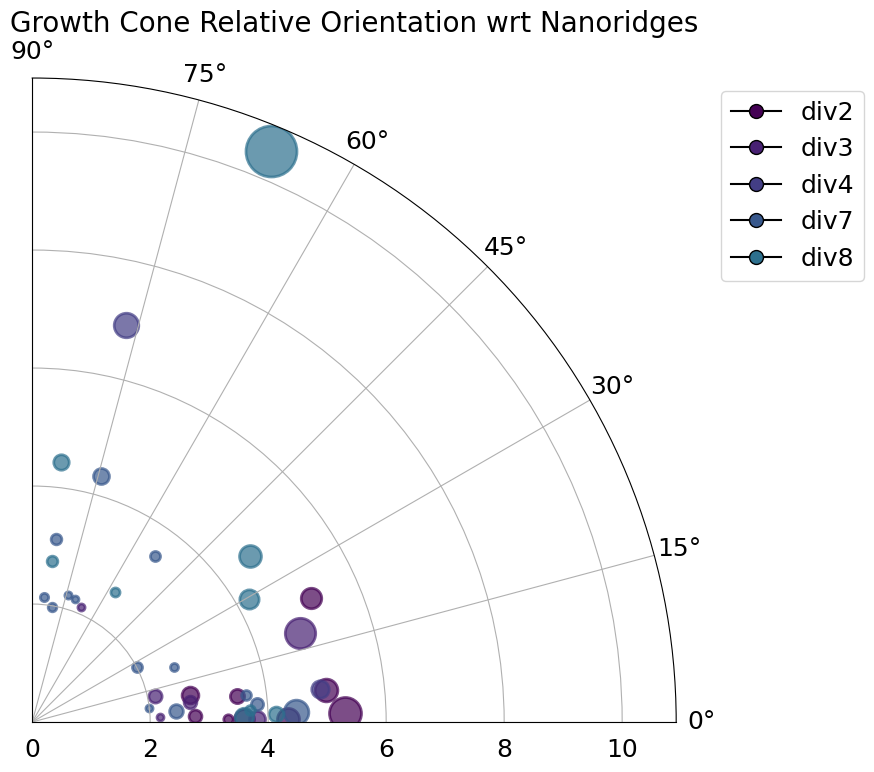

In [99]:
# Initialize the colormap
cmap = plt.colormaps.get_cmap("viridis")

# Access 'n' colors from the colormap
n = len([name for name in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, name))])  # Count level-1 subfolders
folder_colors = [cmap(i / n) for i in range(n)]  # Normalize i to be between 0 and 1

# Extract relative angles, area values, length values, and folder information
folder_names, all_angles, area_values, length_values, first_level_colors, oriented_counts, non_oriented_counts = extract_length_area_and_relative_angles(main_folder)

# Set up the polar plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='polar')
plt.rcParams.update({'font.size': 16})  # Increase global font size

# Set angular limits to only display the first quadrant (0 to π/2 or 90 degrees)
ax.set_thetamin(0)  # Start at 0 degrees
ax.set_thetamax(90)  # End at 90 degrees

# Initialize variables to track the largest and smallest scatter sizes
largest_scatter_size = 0
smallest_scatter_size = float('inf')  # Start with a very high value

# Plot the relative angles with 'length_values' as radius and 'area_values' for scatter sizes
for i, ((relative_angle, color, first_level_folder), area, length) in enumerate(zip(all_angles, area_values, length_values)):
    angle_rad = np.deg2rad(relative_angle)  # Convert relative angle to radians for polar plot

    # The size of each scatter point will be proportional to its corresponding 'area_value'
    scatter_size = area **2 + 10  # Scale the area for better visualization

    # Update largest and smallest scatter sizes
    largest_scatter_size = max(largest_scatter_size, scatter_size)
    smallest_scatter_size = min(smallest_scatter_size, scatter_size)

    ax.scatter(angle_rad, length, s=scatter_size, color=color, alpha=0.7, linewidths=2, 
               label=first_level_folder if i == folder_names.index(folder_names[i]) else "")

# Set title with increased font size
plt.title('Growth Cone Relative Orientation wrt Nanoridges', fontsize=20)

# Create a legend based on the unique first-level folders and their assigned colors
unique_folders = {}
for first_level_folder, color in first_level_colors.items():
    unique_folders[first_level_folder] = plt.Line2D([0], [0], marker='o', color='k', markerfacecolor=color, markersize=10, label=first_level_folder)

# Add a legend (one entry per first-level folder)
plt.legend(handles=unique_folders.values(), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=18)

# Increase tick sizes for better visibility
ax.tick_params(axis='both', which='major', labelsize=18, size=8, width=2)  # Adjust tick parameters

# Adjust layout for better fit
plt.tight_layout()

# Show the polar plot
plt.show()

# Save as SVG with highest resolution
# fig.savefig(main_folder + '\\ridges_growth_cone_angle_vs_width.svg', format='svg', bbox_inches='tight')


### For reference plotting the largest and smallest sizes

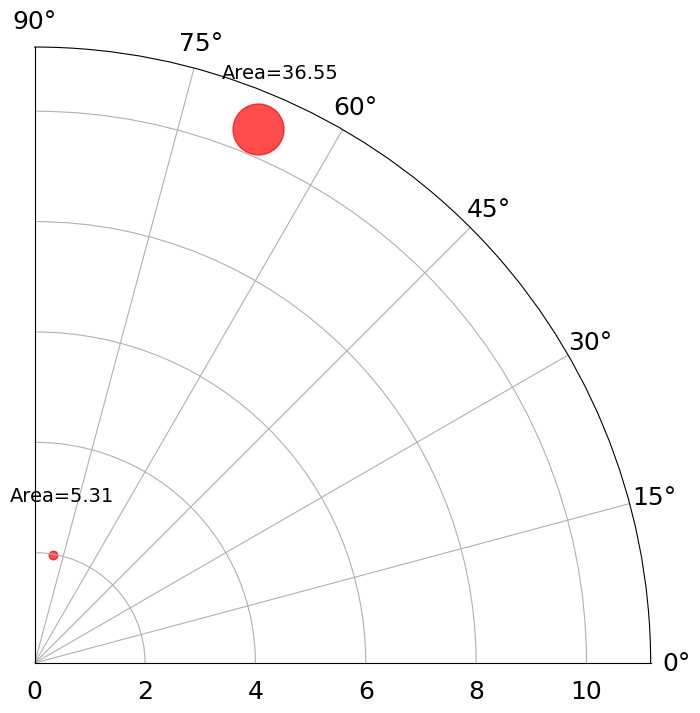

In [100]:
# Initialize the colormap
n = len([name for name in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, name))])  # Count level-1 subfolders
cmap = plt.colormaps.get_cmap("viridis")

# Extract relative angles, area values, length values, and folder information
folder_names, all_angles, area_values, length_values, first_level_colors, oriented_counts, non_oriented_counts = extract_length_area_and_relative_angles(main_folder)

# Identify the largest and smallest area values
min_area, max_area = min(area_values), max(area_values)

# Collect specific points based on the identified lengths
specific_data = [(angle[0] if isinstance(angle, tuple) else angle, area, length) 
                 for angle, area, length in zip(all_angles, area_values, length_values) 
                 if length in {min(length_values), max(length_values)}]

# Set up a new polar plot for these points only
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': 'polar'})
plt.rcParams.update({'font.size': 16})  # Increase global font size

# Set angular limits to only display the first quadrant (0 to π/2 or 90 degrees)
ax.set_thetamin(0)
ax.set_thetamax(90)

# Plot and annotate specific points, using 'length_values' as radial distance and 'area_values' as scatter size
for i, (angle, area, length) in enumerate(specific_data):
    if 0 <= angle <= 90:
        angle_rad = np.deg2rad(angle)  # Convert to radians
        
        # Here, 'length' is used as the radial distance, and 'area' determines the scatter size
        scatter_size = area**2 + 10   # Normalize area to a range and scale
        
        ax.scatter(angle_rad, length, s=scatter_size, color='red', alpha=0.7)

        # Annotate each point on top of the scatter
        ax.annotate(f'Area={area:.2f}', xy=(angle_rad, length), xytext=(angle_rad, length + 1),
                    fontsize=14, color='black', ha='center')  # Adjusted vertical position
        
ax.set_rmax(max_length + largest_scatter_size / 2000)  # Add some padding based on the largest scatter size

# Increase tick sizes for better visibility
ax.tick_params(axis='both', which='major', labelsize=18, size=8, width=2)

plt.show()  # Show the polar plot
# Save as SVG with highest resolution
# fig.savefig(main_folder + '\\ridges_growth_cone_angle_vs_width_annotated.svg', format='svg', bbox_inches='tight')


## New Plots (after feedback)

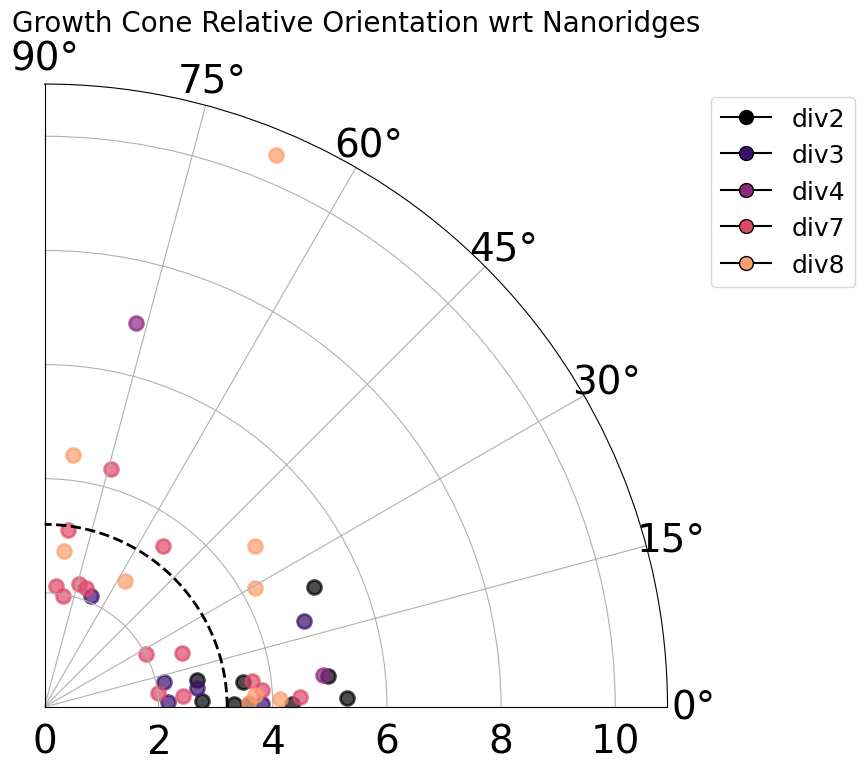

In [107]:
# Initialize the colormap
cmap = plt.colormaps.get_cmap("magma")

# Count level-1 subfolders
n = len([name for name in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, name))])

# Select 5 extreme colors from achosen fraction of the colormap
extreme_indices = np.linspace(0, 0.8, 5)  # Only sample from the first half (darker shades)
extreme_colors = [cmap(i) for i in extreme_indices]  # Extract colors

# Assign colors cyclically if there are more than 5 folders
folder_colors = [extreme_colors[i % 5] for i in range(n)]  

# Extract relative angles, area values, length values, and folder information
folder_names, all_angles, area_values, length_values, first_level_colors, oriented_counts, non_oriented_counts = extract_length_area_and_relative_angles(main_folder)

# Set up the polar plot
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='polar')
plt.rcParams.update({'font.size': 16})  # Increase global font size

# Set angular limits to only display the first quadrant (0 to π/2 or 90 degrees)
ax.set_thetamin(0)  # Start at 0 degrees
ax.set_thetamax(90)  # End at 90 degrees

# Create a quarter-circular dashed line at radial distance 3.2
r = 3.2  # Radial distance
theta = np.linspace(0, np.pi/2, 100)  # Angles from 0 to 90 degrees
ax.plot(theta, [r]*len(theta), color='black', linestyle='--', linewidth=2)  # Dashed circular arc

# ax.plot(theta, [2*r]*len(theta), color='black', linestyle='--', linewidth=2)  # Dashed circular arc

# Fixed scatter point size
scatter_size = 100  # Uniform scatter size for all points

# Plot the relative angles with 'length_values' as radius and uniform scatter sizes
for i, ((relative_angle, color, first_level_folder), area, length) in enumerate(zip(all_angles, area_values, length_values)):
    angle_rad = np.deg2rad(relative_angle)  # Convert relative angle to radians for polar plot

    ax.scatter(angle_rad, length, s=scatter_size, color=color, alpha=0.7, linewidths=2, 
               label=first_level_folder if i == folder_names.index(folder_names[i]) else "")

# Set title with increased font size
plt.title('Growth Cone Relative Orientation wrt Nanoridges', fontsize=20)

# Define specific theta tick values (in radians)
theta_ticks = np.radians([0, 15, 30, 45, 60, 75, 90]) 
theta_labels = ['0°', '15°', '30°', '45°', '60°', '75°', '90°']  # Labels for those ticks

# Set the tick positions
ax.set_xticks(theta_ticks)

# Set the tick labels
ax.set_xticklabels(theta_labels, fontsize=28)

# Create a legend based on the unique first-level folders and their assigned colors
unique_folders = {}
for first_level_folder, color in first_level_colors.items():
    unique_folders[first_level_folder] = plt.Line2D([0], [0], marker='o', color='k', markerfacecolor=color, markersize=10, label=first_level_folder)

# Add a legend (one entry per first-level folder)
plt.legend(handles=unique_folders.values(), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=18)

# Increase tick sizes for better visibility
ax.tick_params(axis='both', which='major', labelsize=28, size=8, width=2)  # Adjust tick parameters

# Adjust layout for better fit
plt.tight_layout()

# Show the polar plot
plt.show()

fig.savefig(main_folder + '\\ridges_growth_cone_angle_vs_width.svg', format='svg', bbox_inches='tight')


## Check the number of Oriented vs Non-oriented Growth Cones

In [38]:
# Display the counts for each div stage
for div_stage in oriented_counts:
    print(f"DIV Stage: {div_stage}")
    print(f"  Oriented Cones (0-15 degrees): {oriented_counts[div_stage]}")
    print(f"  Non-Oriented Cones (15-90 degrees): {non_oriented_counts[div_stage]}")


DIV Stage: div2
  Oriented Cones (0-15 degrees): {'ridges_19_01_21_div2cortex_B1_timelapse2': 0, 'ridges_19_01_21_div2cortex_B1_timelapse3': 1, 'ridges_19_01_21_div2cortex_B1_timelapse5': 1, 'ridges_19_01_21_div2cortex_B1_timelapse6': 1, 'ridges_19_02_11_C2_ridges_timelapse1': 3, 'ridges_19_02_11_C2_ridges_timelapse4a': 1, 'ridges_19_02_11_C2_ridges_timelapse7': 1}
  Non-Oriented Cones (15-90 degrees): {'ridges_19_01_21_div2cortex_B1_timelapse2': 1, 'ridges_19_01_21_div2cortex_B1_timelapse3': 0, 'ridges_19_01_21_div2cortex_B1_timelapse5': 0, 'ridges_19_01_21_div2cortex_B1_timelapse6': 0, 'ridges_19_02_11_C2_ridges_timelapse1': 0, 'ridges_19_02_11_C2_ridges_timelapse4a': 0, 'ridges_19_02_11_C2_ridges_timelapse7': 0}
DIV Stage: div3
  Oriented Cones (0-15 degrees): {'ridges_2018_11_02_MAX_cortical_glass+PDL+Lam_timelapse1': 1, 'ridges_2021_04_16_MAX_well2_timelapse2_PFS': 1, 'ridges_2021_04_16_MAX_well2_timelapse3_PFS': 2, 'ridges_2021_04_16_well2_timelapse1_PFS': 0}
  Non-Oriented Cones

## Grouped Bar Charts for Early and Mid-stage 

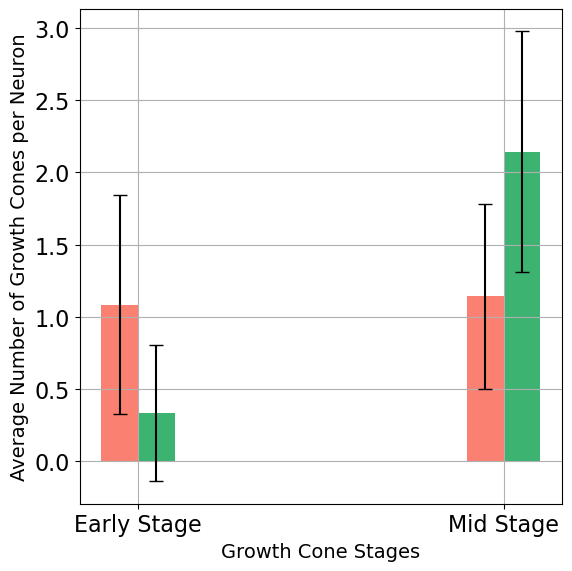

In [66]:
def plot_growth_cone_statistics(oriented_counts, non_oriented_counts):
    """
    Function to plot the average number of oriented and non-oriented growth cones
    per level-2 folder as a function of div stages (level-1 folders) with error bars.
    
    Perform:
    - Paired t-tests within early and late stages (oriented vs non-oriented).
    - Unpaired t-tests between early and late stages (oriented and non-oriented separately).

    Args:
    - oriented_counts: Nested dictionary of oriented growth cone counts for each level-2 folder under each div stage.
    - non_oriented_counts: Nested dictionary of non-oriented growth cone counts for each level-2 folder under each div stage.
    """
    div_stages = []
    oriented_means = []
    oriented_stddevs = []
    non_oriented_means = []
    non_oriented_stddevs = []

    # Store the oriented and non-oriented values for each div stage
    grouped_oriented_values = {}
    grouped_non_oriented_values = {}

    # Loop through div stages
    for div_stage in oriented_counts:
        div_stages.append(div_stage)

        # Extract oriented and non-oriented counts for each neuron in this div stage
        oriented_values = list(oriented_counts[div_stage].values())
        non_oriented_values = list(non_oriented_counts[div_stage].values())

        # Store values for later t-tests
        grouped_oriented_values[div_stage] = oriented_values
        grouped_non_oriented_values[div_stage] = non_oriented_values

        # Calculate means and standard deviations for plotting
        oriented_mean = np.mean(oriented_values)
        oriented_std = np.std(oriented_values)
        non_oriented_mean = np.mean(non_oriented_values)
        non_oriented_std = np.std(non_oriented_values)

        oriented_means.append(oriented_mean)
        oriented_stddevs.append(oriented_std)
        non_oriented_means.append(non_oriented_mean)
        non_oriented_stddevs.append(non_oriented_std)

    # Grouping: Combine div2 + div3 + div4 as early stage, div7 + div8 as late stage
    early_stage_oriented = grouped_oriented_values['div2'] + grouped_oriented_values['div3'] + grouped_oriented_values['div4']  # Early stage
    late_stage_oriented = grouped_oriented_values['div7'] + grouped_oriented_values['div8']   # Late stage

    early_stage_non_oriented = grouped_non_oriented_values['div2'] + grouped_non_oriented_values['div3'] + grouped_non_oriented_values['div4']  # Early stage
    late_stage_non_oriented = grouped_non_oriented_values['div7'] + grouped_non_oriented_values['div8']   # Late stage

    # # 1. Unpaired t-tests: Compare early vs late stages for both oriented and non-oriented neurons
    # ttest_oriented_across_stages = ttest_ind(early_stage_oriented, late_stage_oriented)
    # ttest_non_oriented_across_stages = ttest_ind(early_stage_non_oriented, late_stage_non_oriented)

    # print(f"Unpaired t-test between early and late stages (oriented): {ttest_oriented_across_stages}")
    # print(f"Unpaired t-test between early and late stages (non-oriented): {ttest_non_oriented_across_stages}")

    # # 2. Paired t-tests within each stage (oriented vs non-oriented)
    # ttest_early_stage_paired = ttest_rel(early_stage_oriented, early_stage_non_oriented)
    # ttest_late_stage_paired = ttest_rel(late_stage_oriented, late_stage_non_oriented)

    # print(f"Paired t-test within early stage (oriented vs non-oriented): {ttest_early_stage_paired}")
    # print(f"Paired t-test within late stage (oriented vs non-oriented): {ttest_late_stage_paired}")

    # Calculate means and standard deviations for grouped stages
    grouped_means_oriented = [
        np.mean(early_stage_oriented),  # Early stage
        np.mean(late_stage_oriented)    # Late stage
    ]
    grouped_stddevs_oriented = [
        np.std(early_stage_oriented),  # Early stage
        np.std(late_stage_oriented)    # Late stage
    ]

    grouped_means_non_oriented = [
        np.mean(early_stage_non_oriented),  # Early stage
        np.mean(late_stage_non_oriented)    # Late stage
    ]
    grouped_stddevs_non_oriented = [
        np.std(early_stage_non_oriented),  # Early stage
        np.std(late_stage_non_oriented)    # Late stage
    ]

    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 6))

    # Define the bar positions
    bar_width = 0.1  # Width of the bars
    index = np.arange(len(grouped_means_oriented))

    # Plot bars for oriented and non-oriented growth cones
    bars1 = ax.bar(index - bar_width/2, grouped_means_oriented, bar_width, yerr=grouped_stddevs_oriented,
                   label='Oriented Growth Cones (0-15°)', color='salmon', capsize=5)
    bars2 = ax.bar(index + bar_width/2, grouped_means_non_oriented, bar_width, yerr=grouped_stddevs_non_oriented,
                   label='Non-Oriented Growth Cones (15-90°)', color='mediumseagreen', capsize=5)

    # Set labels and title
    ax.set_xlabel('Growth Cone Stages', fontsize=14)
    ax.set_ylabel('Average Number of Growth Cones per Neuron', fontsize=14)

    # Set x-ticks positions closer together
    ax.set_xticks(index)
    ax.set_xticklabels(['Early Stage', 'Mid Stage'], position=(0.0, 0.0))

    # Add legend
    # ax.legend()

    # Show the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save the plot as SVG with highest resolution
    # Uncomment the next line if you want to save the plot
    # fig.savefig(main_folder + '\\ridges_oriented_non_oriented_cones_barplots.svg', format='svg', bbox_inches='tight')

# Example usage (ensure to replace with your actual counts)
plot_growth_cone_statistics(oriented_counts, non_oriented_counts)


In [73]:
def get_significance_stars(p_value):
    """Returns significance stars based on p-value."""
    if p_value < 0.001:
        return '***'  # p < 0.001
    elif p_value < 0.01:
        return '**'   # p < 0.01
    elif p_value < 0.05:
        return '*'    # p < 0.05
    else:
        return 'ns'   # Not significant

def plot_growth_cone_statistics(oriented_counts, non_oriented_counts):
    # Store the oriented and non-oriented values for each div stage
    grouped_oriented_values = {}
    grouped_non_oriented_values = {}

    # Loop through div stages
    for div_stage in oriented_counts:
        grouped_oriented_values[div_stage] = list(oriented_counts[div_stage].values())
        grouped_non_oriented_values[div_stage] = list(non_oriented_counts[div_stage].values())

    # Grouping: Early (div2, div3, div4) and Late (div7, div8)
    early_stage_oriented = grouped_oriented_values['div2'] + grouped_oriented_values['div3'] + grouped_oriented_values['div4']
    late_stage_oriented = grouped_oriented_values['div7'] + grouped_oriented_values['div8']
    early_stage_non_oriented = grouped_non_oriented_values['div2'] + grouped_non_oriented_values['div3'] + grouped_non_oriented_values['div4']
    late_stage_non_oriented = grouped_non_oriented_values['div7'] + grouped_non_oriented_values['div8']

    # ➤ Normality Test
    def check_normality(data, label):
        stat, p = shapiro(data)
        print(f"{label}: Normality test {'PASSED' if p > 0.05 else 'FAILED'} (p = {p:.6f})")

    print("\n--- Normality Test Results ---")
    check_normality(early_stage_oriented, "Early Stage Oriented")
    check_normality(late_stage_oriented, "Late Stage Oriented")
    check_normality(early_stage_non_oriented, "Early Stage Non-Oriented")
    check_normality(late_stage_non_oriented, "Late Stage Non-Oriented")

    # ➤ Mann-Whitney U tests with significance stars
    mw_oriented_across_stages = mannwhitneyu(early_stage_oriented, late_stage_oriented, alternative='two-sided')
    mw_non_oriented_across_stages = mannwhitneyu(early_stage_non_oriented, late_stage_non_oriented, alternative='two-sided')
    mw_early_stage_intra = mannwhitneyu(early_stage_oriented, early_stage_non_oriented, alternative='two-sided')
    mw_late_stage_intra = mannwhitneyu(late_stage_oriented, late_stage_non_oriented, alternative='two-sided')

    # Display results with significance stars
    print(f"\nMann-Whitney U test (early vs late stages, oriented): U = {mw_oriented_across_stages.statistic}, "
          f"p = {mw_oriented_across_stages.pvalue:.6f} {get_significance_stars(mw_oriented_across_stages.pvalue)}")

    print(f"Mann-Whitney U test (early vs late stages, non-oriented): U = {mw_non_oriented_across_stages.statistic}, "
          f"p = {mw_non_oriented_across_stages.pvalue:.6f} {get_significance_stars(mw_non_oriented_across_stages.pvalue)}")

    print(f"\nMann-Whitney U test (early stage, oriented vs non-oriented): U = {mw_early_stage_intra.statistic}, "
          f"p = {mw_early_stage_intra.pvalue:.6f} {get_significance_stars(mw_early_stage_intra.pvalue)}")

    print(f"Mann-Whitney U test (late stage, oriented vs non-oriented): U = {mw_late_stage_intra.statistic}, "
          f"p = {mw_late_stage_intra.pvalue:.6f} {get_significance_stars(mw_late_stage_intra.pvalue)}")

plot_growth_cone_statistics(oriented_counts, non_oriented_counts)



--- Normality Test Results ---
Early Stage Oriented: Normality test FAILED (p = 0.004335)
Late Stage Oriented: Normality test PASSED (p = 0.099451)
Early Stage Non-Oriented: Normality test FAILED (p = 0.000125)
Late Stage Non-Oriented: Normality test PASSED (p = 0.061550)

Mann-Whitney U test (early vs late stages, oriented): U = 38.0, p = 0.731315 ns
Mann-Whitney U test (early vs late stages, non-oriented): U = 4.0, p = 0.000787 ***

Mann-Whitney U test (early stage, oriented vs non-oriented): U = 112.0, p = 0.010975 *
Mann-Whitney U test (late stage, oriented vs non-oriented): U = 10.0, p = 0.058261 ns


# Generalized Growth cone orientation count (excluding movies without growth cones)

In [50]:
def extract_length_area_and_relative_angles(main_folder):
    """
    Function to extract length, area, relative angles, and count growth cones in 6 bins between 0 and 90 degrees,
    only if 'Results.csv' exists in the subfolder.

    Args:
    - main_folder: Path to the main folder containing the data.

    Returns:
    - folder_names: List of subfolder names for labeling in scatter plot.
    - all_angles: List of tuples containing relative angle, subfolder color, and first-level folder name.
    - area_values: List of 'Area' values for radius.
    - length_values: List of 'Length' values for scatter sizes.
    - first_level_colors: Dictionary mapping first-level folders to colors.
    - angle_bin_counts: Dictionary storing counts of growth cones in 6 bins for each level-2 subfolder.
    """

    bins = np.linspace(0, 90, 7)  # 6 equally spaced bins
    
    relative_angles = []
    folder_names = []
    all_angles = []
    area_values = []
    length_values = []
    first_level_colors = {}
    color_count = 0
    
    angle_bin_counts = {}  # Dictionary to store bin counts

    for root, dirs, files in os.walk(main_folder):
        current_depth = root.count(os.sep)
        target_depth = main_folder.count(os.sep) + 2
        
        if current_depth == target_depth:
            subfolder = os.path.basename(root)
            first_level_folder = os.path.basename(os.path.dirname(root))

            # Check if 'Results.csv' exists; skip this subfolder if not found
            if not any(file.startswith('Results') and file.endswith('.csv') for file in files):
                print(f"Skipping {subfolder} as 'Results.csv' is missing.")
                continue

            if first_level_folder not in first_level_colors:
                first_level_colors[first_level_folder] = folder_colors[color_count % len(folder_colors)]
                color_count += 1

            if first_level_folder not in angle_bin_counts:
                angle_bin_counts[first_level_folder] = {}
            angle_bin_counts[first_level_folder][subfolder] = np.zeros(6, dtype=int)

            subfolder_color = first_level_colors[first_level_folder]
            angle_deg = None

            # Load skeleton orientation if available
            for file in files:
                if file.endswith('skeleton_orientation.mat'):
                    mat_path = os.path.join(root, file)
                    try:
                        mat_data = loadmat(mat_path)
                        if 'angle_deg' in mat_data:
                            angle_deg = mat_data['angle_deg'].flatten()[0]
                    except Exception as e:
                        print(f"Error loading {mat_path}: {e}")
            
            if angle_deg is None:
                continue

            for file in files:
                if file.startswith('Results') and file.endswith('.csv'):
                    file_path = os.path.join(root, file)
                    try:
                        df = pd.read_csv(file_path)
                        if 'Angle' in df.columns:
                            csv_angle = df['Angle'].iloc[0]
                            csv_angle_perpendicular = (csv_angle + 90) % 180
                            if csv_angle_perpendicular < 0:
                                csv_angle_perpendicular += 180
                            
                            relative_angle = abs(csv_angle_perpendicular - angle_deg)
                            if relative_angle > 90:
                                relative_angle = 180 - relative_angle
                            if relative_angle > 90:
                                continue

                            relative_angles.append(relative_angle)
                            
                            if 'Area' in df.columns:
                                area_values.append(df['Area'].iloc[1])
                            if 'Length' in df.columns:
                                length_values.append(df['Length'].iloc[0])

                            folder_names.append(subfolder)
                            all_angles.append((relative_angle, subfolder_color, first_level_folder))
                            
                            bin_idx = np.digitize(relative_angle, bins) - 1
                            if 0 <= bin_idx < 6:
                                angle_bin_counts[first_level_folder][subfolder][bin_idx] += 1

                    except Exception as e:
                        print(f"Error processing file {file_path}: {e}")

    return folder_names, all_angles, area_values, length_values, first_level_colors, angle_bin_counts


In [51]:
# Define the main folder
main_folder = r'E:\Spandan\2D_Neurons_Paper\Ridges'

# Access 'n' colors from the colormap
n = len([name for name in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, name))])  # Count level-1 subfolders 

# Extract relative angles, area values, length values, and folder information
folder_names, all_angles, area_values, length_values, first_level_colors, angle_bin_counts = extract_length_area_and_relative_angles(main_folder)

Skipping ridges_2019_02_11_C2_ridges_timelapse2 as 'Results.csv' is missing.
Skipping ridges_2021_04_16_MAX_well1_div7ridges_timelapse1 as 'Results.csv' is missing.
Skipping ridges_2021_04_16_MAX_well1_div7ridges_timelapse2 as 'Results.csv' is missing.


In [52]:
angle_bin_counts

{'div2': {'ridges_19_01_21_div2cortex_B1_timelapse2': array([0, 1, 0, 0, 0, 0]),
  'ridges_19_01_21_div2cortex_B1_timelapse3': array([1, 0, 0, 0, 0, 0]),
  'ridges_19_01_21_div2cortex_B1_timelapse5': array([1, 0, 0, 0, 0, 0]),
  'ridges_19_01_21_div2cortex_B1_timelapse6': array([1, 0, 0, 0, 0, 0]),
  'ridges_19_02_11_C2_ridges_timelapse1': array([3, 0, 0, 0, 0, 0]),
  'ridges_19_02_11_C2_ridges_timelapse4a': array([1, 0, 0, 0, 0, 0]),
  'ridges_19_02_11_C2_ridges_timelapse7': array([1, 0, 0, 0, 0, 0])},
 'div3': {'ridges_2018_11_02_MAX_cortical_glass+PDL+Lam_timelapse1': array([1, 1, 0, 0, 0, 0]),
  'ridges_2021_04_16_MAX_well2_timelapse2_PFS': array([1, 0, 0, 0, 0, 0]),
  'ridges_2021_04_16_MAX_well2_timelapse3_PFS': array([2, 0, 0, 0, 0, 0]),
  'ridges_2021_04_16_well2_timelapse1_PFS': array([0, 0, 0, 0, 1, 0])},
 'div4': {'ridges_2019_02_11_C2_ridges_timelapse1': array([1, 0, 0, 0, 0, 1])},
 'div7': {'ridges_2019_01_21_B1_ridges_timelapse1': array([2, 0, 0, 1, 1, 0]),
  'ridges_2019

C:\Users\spandanp\AppData\Local\Temp\ipykernel_3372\3732630741.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.linspace(0, 1.2, 5), fontsize=20)


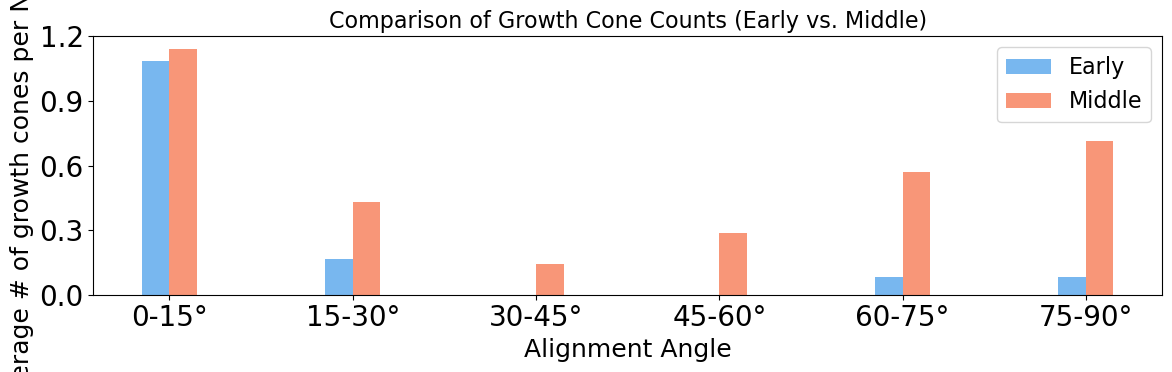

In [110]:
def plot_growth_cone_barplots(angle_bin_counts):
    """
    Function to plot barplots of the number of growth cones per neuron,
    categorized into 6 orientation bins (0-90°), for early-stage vs middle-stage.

    Args:
    - angle_bin_counts: Nested dictionary {div_stage: {subfolder: [bin_counts]}}
    """
    # Define early and middle-stage DIV groups
    early_stages = {'div2', 'div3', 'div4'}
    middle_stages = {'div7', 'div8'}
    
    bins = np.linspace(0, 90, 7)  # 6 bins: [0-15, 15-30, ..., 75-90]
    bin_labels = [f"{int(bins[i])}-{int(bins[i+1])}°" for i in range(len(bins) - 1)]
    
    # Initialize storage for the bin data
    early_bin_data = {label: [] for label in bin_labels}
    middle_bin_data = {label: [] for label in bin_labels}
    
    # Process subfolders within each stage
    for div_stage, subfolders in angle_bin_counts.items():
        if div_stage in early_stages:
            target_data = early_bin_data
        elif div_stage in middle_stages:
            target_data = middle_bin_data
        else:
            continue  # Ignore other stages
        
        for subfolder_counts in subfolders.values():
            for i, label in enumerate(bin_labels):
                target_data[label].append(subfolder_counts[i])  # Store bin count
    
    # Prepare data for the bar plot
    early_means = [np.mean(early_bin_data[label]) for label in bin_labels]
    early_stds = [np.std(early_bin_data[label]) for label in bin_labels]
    
    middle_means = [np.mean(middle_bin_data[label]) for label in bin_labels]
    middle_stds = [np.std(middle_bin_data[label]) for label in bin_labels]

    # Create the bar plot
    bar_width = 0.15
    index = np.arange(len(bin_labels))

    fig, ax = plt.subplots(figsize=(12, 4))

    color_labels = ['#1E88E5', '#F4511E']

    # Plot bars for early and middle stages
    bars1 = ax.bar(index - bar_width/2, early_means, bar_width, 
                   label='Early', color=color_labels[0], capsize=5, alpha=0.6)
    bars2 = ax.bar(index + bar_width/2, middle_means, bar_width, 
                   label='Middle', color=color_labels[1], capsize=5, alpha=0.6)

    # Set labels and title
    ax.set_xlabel('Alignment Angle', fontsize=18)
    ax.set_ylabel('Average # of growth cones per Neuron', fontsize=18)
    ax.set_title('Comparison of Growth Cone Counts (Early vs. Middle)', fontsize=16)
    ax.set_yticks(np.linspace(0, 1.2, 5))
    ax.set_xticklabels(np.linspace(0, 1.2, 5), fontsize=20)

    # Set x-ticks positions and labels
    ax.set_xticks(index)
    ax.set_xticklabels(bin_labels)

    # Customize tick sizes
    ax.tick_params(axis='both', labelsize=20)

    # Add legend
    ax.legend()

    # Show the plot
    # plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save the plot as SVG with highest resolution
    # Uncomment the next line if you want to save the plot
    fig.savefig(main_folder + '\\growth_cone_barplots_combined.svg', format='svg', bbox_inches='tight')

# Example call:
plot_growth_cone_barplots(angle_bin_counts)


## Normality test for the avg. number of growth cones

Mann-Whitney U test (0-15° vs 75-90° in Early Stage): p = 0.000398 ***
Mann-Whitney U test (0-15° vs 75-90° in Middle Stage): p = 0.250241 ns


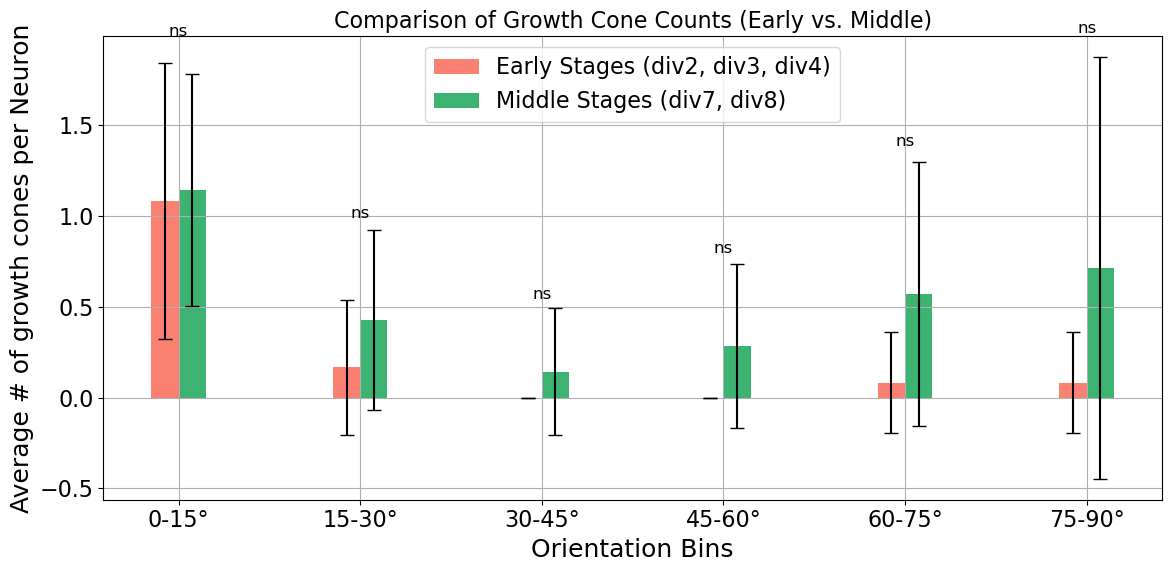

In [111]:
from scipy.stats import mannwhitneyu

def significance_stars(p_value):
    """Return significance stars based on p-value."""
    if p_value <= 0.001:
        return '***'
    elif p_value <= 0.01:
        return '**'
    elif p_value <= 0.05:
        return '*'
    else:
        return 'ns'

def plot_growth_cone_barplots(angle_bin_counts):
    """
    Function to plot barplots of the number of growth cones per neuron,
    categorized into 6 orientation bins (0-90°), for early-stage vs middle-stage.
    It includes Mann-Whitney U test results and scatter points of the average number of growth cones.

    Args:
    - angle_bin_counts: Nested dictionary {div_stage: {subfolder: [bin_counts]}}
    """
    # Define early and middle-stage DIV groups
    early_stages = {'div2', 'div3', 'div4'}
    middle_stages = {'div7', 'div8'}
    
    bins = np.linspace(0, 90, 7)  # 6 bins: [0-15, 15-30, ..., 75-90]
    bin_labels = [f"{int(bins[i])}-{int(bins[i+1])}°" for i in range(len(bins) - 1)]
    
    # Initialize storage for the bin data
    early_bin_data = {label: [] for label in bin_labels}
    middle_bin_data = {label: [] for label in bin_labels}
    
    # Process subfolders within each stage
    for div_stage, subfolders in angle_bin_counts.items():
        target_data = early_bin_data if div_stage in early_stages else middle_bin_data if div_stage in middle_stages else None
        if target_data is None:
            continue
        
        for subfolder_counts in subfolders.values():
            for i, label in enumerate(bin_labels):
                target_data[label].append(subfolder_counts[i])  # Store bin count

    # Prepare data for the bar plot
    early_means = [np.mean(early_bin_data[label]) for label in bin_labels]
    early_stds = [np.std(early_bin_data[label]) for label in bin_labels]

    middle_means = [np.mean(middle_bin_data[label]) for label in bin_labels]
    middle_stds = [np.std(middle_bin_data[label]) for label in bin_labels]

    # Perform Mann-Whitney U test for each bin
    mw_stats = []
    mw_p_values = []
    for i, label in enumerate(bin_labels):
        stat, p = mannwhitneyu(early_bin_data[label], middle_bin_data[label], alternative='two-sided')
        mw_stats.append(stat)
        mw_p_values.append(p)

    # ➤ Additional Mann-Whitney U tests for 0-15° vs 75-90° bins
    mw_oriented_early = mannwhitneyu(early_bin_data['0-15°'], early_bin_data['75-90°'], alternative='two-sided')
    mw_oriented_middle = mannwhitneyu(middle_bin_data['0-15°'], middle_bin_data['75-90°'], alternative='two-sided')

    print(f"Mann-Whitney U test (0-15° vs 75-90° in Early Stage): p = {mw_oriented_early.pvalue:.6f} {significance_stars(mw_oriented_early.pvalue)}")
    print(f"Mann-Whitney U test (0-15° vs 75-90° in Middle Stage): p = {mw_oriented_middle.pvalue:.6f} {significance_stars(mw_oriented_middle.pvalue)}")

    # Create the bar plot
    bar_width = 0.15
    index = np.arange(len(bin_labels))

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot bars for early and middle stages
    ax.bar(index - bar_width/2, early_means, bar_width, yerr=early_stds,
           label='Early Stages (div2, div3, div4)', color='salmon', capsize=5)
    ax.bar(index + bar_width/2, middle_means, bar_width, yerr=middle_stds,
           label='Middle Stages (div7, div8)', color='mediumseagreen', capsize=5)

    # Annotate Mann-Whitney results with significance stars
    for i, p_val in enumerate(mw_p_values):
        ax.annotate(f"{significance_stars(p_val)}", 
                    xy=(index[i], max(early_means[i], middle_means[i]) + max(early_stds[i], middle_stds[i]) * 1.1),
                    xycoords='data', ha='center', va='bottom', fontsize=12)

    # Set labels and title
    ax.set_xlabel('Orientation Bins', fontsize=18)
    ax.set_ylabel('Average # of growth cones per Neuron', fontsize=18)
    ax.set_title('Comparison of Growth Cone Counts (Early vs. Middle)', fontsize=16)

    # Set x-ticks positions and labels
    ax.set_xticks(index)
    ax.set_xticklabels(bin_labels)

    # Add legend
    ax.legend()

    # Show the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example call:
plot_growth_cone_barplots(angle_bin_counts)


## Number of movies (with growth cones) per div stage

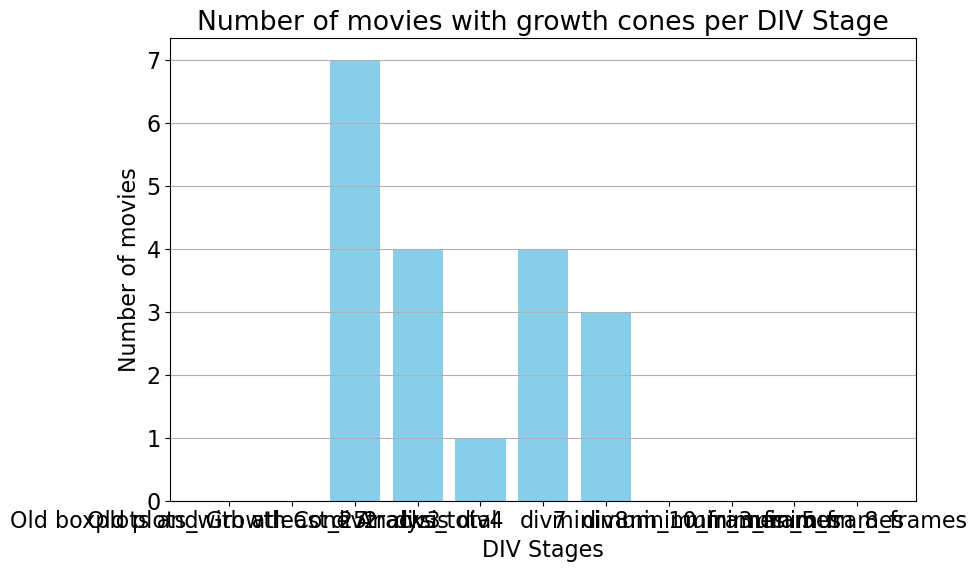

In [46]:
# Function to count the number of level-2 subfolders with 'Results*.csv' in each level-1 subfolder
def count_csv_files_per_level_1_subfolder(main_folder):
    div_csv_counts = {}

    for div_stage in os.listdir(main_folder):
        div_path = os.path.join(main_folder, div_stage)
        
        if os.path.isdir(div_path):
            csv_count = 0

            # Loop through level-2 subfolders
            for level_2_subfolder in os.listdir(div_path):
                level_2_path = os.path.join(div_path, level_2_subfolder)
                
                if os.path.isdir(level_2_path):
                    # Check for any 'Results*.csv' files
                    csv_files = [file for file in os.listdir(level_2_path) if file.startswith('Results') and file.endswith('.csv')]
                    if csv_files:
                        csv_count += 1

            div_csv_counts[div_stage] = csv_count

    return div_csv_counts

# Function to plot the number of level-2 subfolders with 'Results*.csv' in each level-1 subfolder
def plot_csv_file_counts_per_div(div_csv_counts):
    div_stages = sorted(div_csv_counts.keys())
    csv_counts = [div_csv_counts[div] for div in div_stages]

    # Set up the figure
    plt.figure(figsize=(10, 6))

    # Plot the number of .csv files for each DIV stage
    plt.bar(div_stages, csv_counts, color='skyblue')

    # Add labels, title, and grid
    plt.xlabel('DIV Stages')
    plt.ylabel('Number of movies')
    plt.title('Number of movies with growth cones per DIV Stage')
    plt.grid(axis='y')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage:
# main_folder = 'path_to_your_main_folder'  # Replace with your main folder path
div_csv_counts = count_csv_files_per_level_1_subfolder(main_folder)
plot_csv_file_counts_per_div(div_csv_counts)


## Area vs Width relation

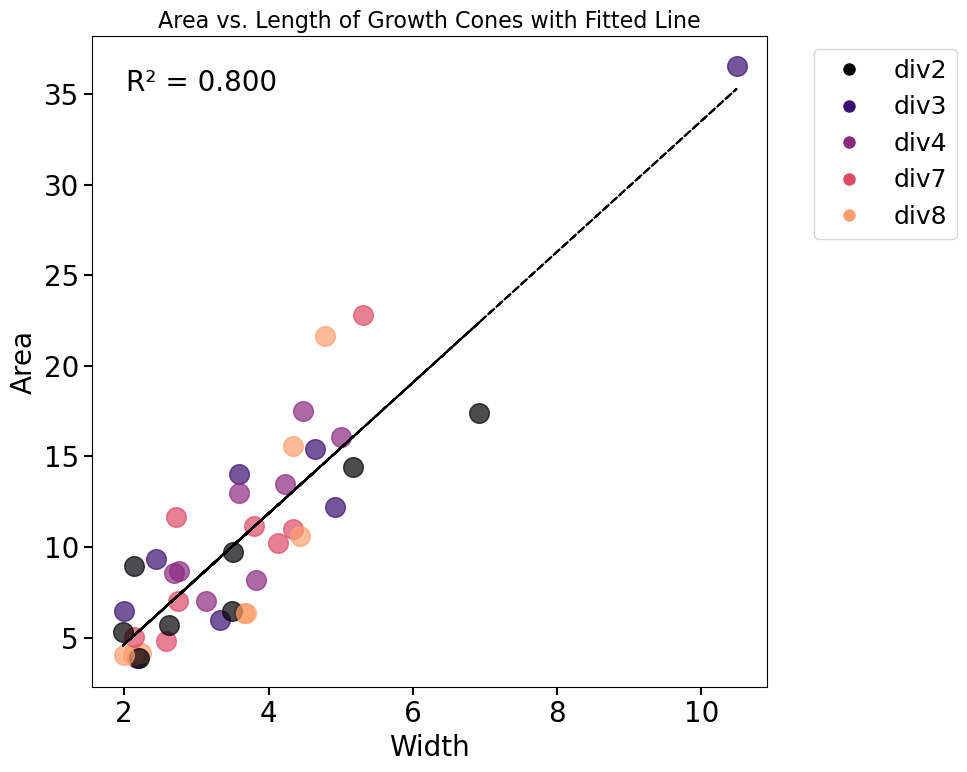

In [276]:

# Initialize the colormap
cmap = plt.colormaps.get_cmap("magma")

# Define the main folder
main_folder = r'E:\Spandan\2D_Neurons_Paper\Ridges'

# Access 'n' colors from the colormap
n = len([name for name in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, name))])  # Count level-1 subfolders 
folder_colors = [cmap(i / n) for i in range(n)]  # Normalize i to be between 0 and 1

# Extract relative angles, area values, length values, and folder information
folder_names, all_angles, area_values, length_values, first_level_colors, oriented_counts, non_oriented_counts = extract_length_area_and_relative_angles(main_folder)

# Set up the scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
plt.rcParams.update({'font.size': 16})  # Increase global font size

# Convert area_values and length_values to numpy arrays for regression
area_values = np.array(area_values)
length_values = np.array(length_values)

# Scatter plot of area vs. length
for i, (area, length) in enumerate(zip(area_values, length_values)):
    ax.scatter(length, area, 200, color=folder_colors[i % n], alpha=0.7, label=folder_names[i] if i == folder_names.index(folder_names[i]) else "")

# Fit a linear regression model (area = slope * length + intercept)
model = LinearRegression()
length_values_reshaped = length_values.reshape(-1, 1)  # Reshape for sklearn
model.fit(length_values_reshaped, area_values)

# Predict area values based on the fitted line
area_fit = model.predict(length_values_reshaped)

# Calculate R²
r_squared = model.score(length_values_reshaped, area_values)
# Annotate the R² value on the plot
ax.text(0.05, 0.95, f'R² = {r_squared:.3f}', transform=ax.transAxes, fontsize=20, verticalalignment='top')

# Plot the fitted line
ax.plot(length_values, area_fit, color='black', linestyle='--', label='Fitted Line')

# Add labels, title, and legend
ax.set_xlabel('Width', fontsize=20)
ax.set_ylabel('Area', fontsize=20)
ax.set_title('Area vs. Length of Growth Cones with Fitted Line', fontsize=16)

# Add a legend (based on unique first-level folders)
unique_folders = {}
for first_level_folder, color in first_level_colors.items():
    unique_folders[first_level_folder] = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=first_level_folder)

# Add a legend (one entry per first-level folder)
plt.legend(handles=unique_folders.values(), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=18)

# Increase tick sizes for better visibility
ax.tick_params(axis='both', which='major', labelsize=20, size=6, width=1.5)

# Adjust layout for better fit
plt.tight_layout()

# Show the scatter plot
plt.show()

# Save the plot as SVG with high resolution
# fig.savefig(main_folder + '\\area_vs_length_fitted_line.svg', format='svg', bbox_inches='tight')


In [303]:
# Initialize arrays to hold DIV stages and corresponding width values
div_stages = []
length_values = []

# Call the function to extract values from all folders
folder_names, all_angles, area_values, length_values, first_level_colors, oriented_counts, non_oriented_counts = extract_length_area_and_relative_angles(main_folder)

# Loop through each folder to extract width values and determine DIV stages
for folder_name in folder_names:
    if folder_name.startswith('div') and folder_name[3:].isdigit():  # Check if folder is a valid div folder
        # Extract the DIV stage
        div_stage = int(folder_name[3:])  # Get the number after 'div'
        div_stages.append(div_stage)

# Check if there are valid data points before plotting
if div_stages and length_values:
    n = len(div_stages)  # Number of valid div stages
    folder_colors = [cmap(i / n) for i in range(n)]  # Normalize i to be between 0 and 1

    # Set up the scatter plot
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.rcParams.update({'font.size': 16})  # Increase global font size

    # Convert lists to numpy arrays for plotting
    div_stages = np.array(div_stages)
    length_values = np.array(length_values)

    # Scatter plot of width vs. DIV stage
    for i in range(n):
        ax.scatter(div_stages[i], length_values[i], 200, color=folder_colors[i], alpha=0.7)

    # Fit a linear regression model (width = slope * DIV + intercept)
    model = LinearRegression()
    div_stages_reshaped = div_stages.reshape(-1, 1)  # Reshape for sklearn
    model.fit(div_stages_reshaped, length_values)

    # Predict width values based on the fitted line
    width_fit = model.predict(div_stages_reshaped)

    # Calculate R²
    r_squared = model.score(div_stages_reshaped, length_values)

    # Annotate the R² value on the plot
    ax.text(0.05, 0.95, f'R² = {r_squared:.3f}', transform=ax.transAxes, fontsize=20, verticalalignment='top')

    # Plot the fitted line
    ax.plot(div_stages, width_fit, color='black', linestyle='--', label='Fitted Line')

    # Add labels, title, and legend
    ax.set_xlabel('DIV Stage', fontsize=20)
    ax.set_ylabel('Width', fontsize=20)
    ax.set_title('Width vs. DIV Stages with Fitted Line', fontsize=16)

    # Increase tick sizes for better visibility
    ax.tick_params(axis='both', which='major', labelsize=20, size=6, width=1.5)

    # Adjust layout for better fit
    plt.tight_layout()

    # Show the scatter plot
    plt.show()

    # Save the plot as SVG with high resolution
    # fig.savefig(main_folder + '\\width_vs_div_stages_fitted_line.svg', format='svg', bbox_inches='tight')
else:
    print("No valid data to plot.")


No valid data to plot.
